In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

- 下载之后将数据集chest_xray复制到当前目录

In [1]:
import torch
from torchvision import transforms, datasets

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [3]:
device

'mps'

In [4]:
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 10

In [5]:
train_trans = transforms.Compose([
    transforms.Resize(300),
    transforms.RandomResizedCrop(300),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_trans = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
import os

root_path = './chest_xray'
train_dir = os.path.join(root_path, 'train')
val_dir = os.path.join(root_path, 'val')

In [7]:
train_datasets = datasets.ImageFolder(train_dir, transform=train_trans)
val_datasets = datasets.ImageFolder(val_dir, transform=val_trans)

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_datasets, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_datasets, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
labels = train_datasets.classes

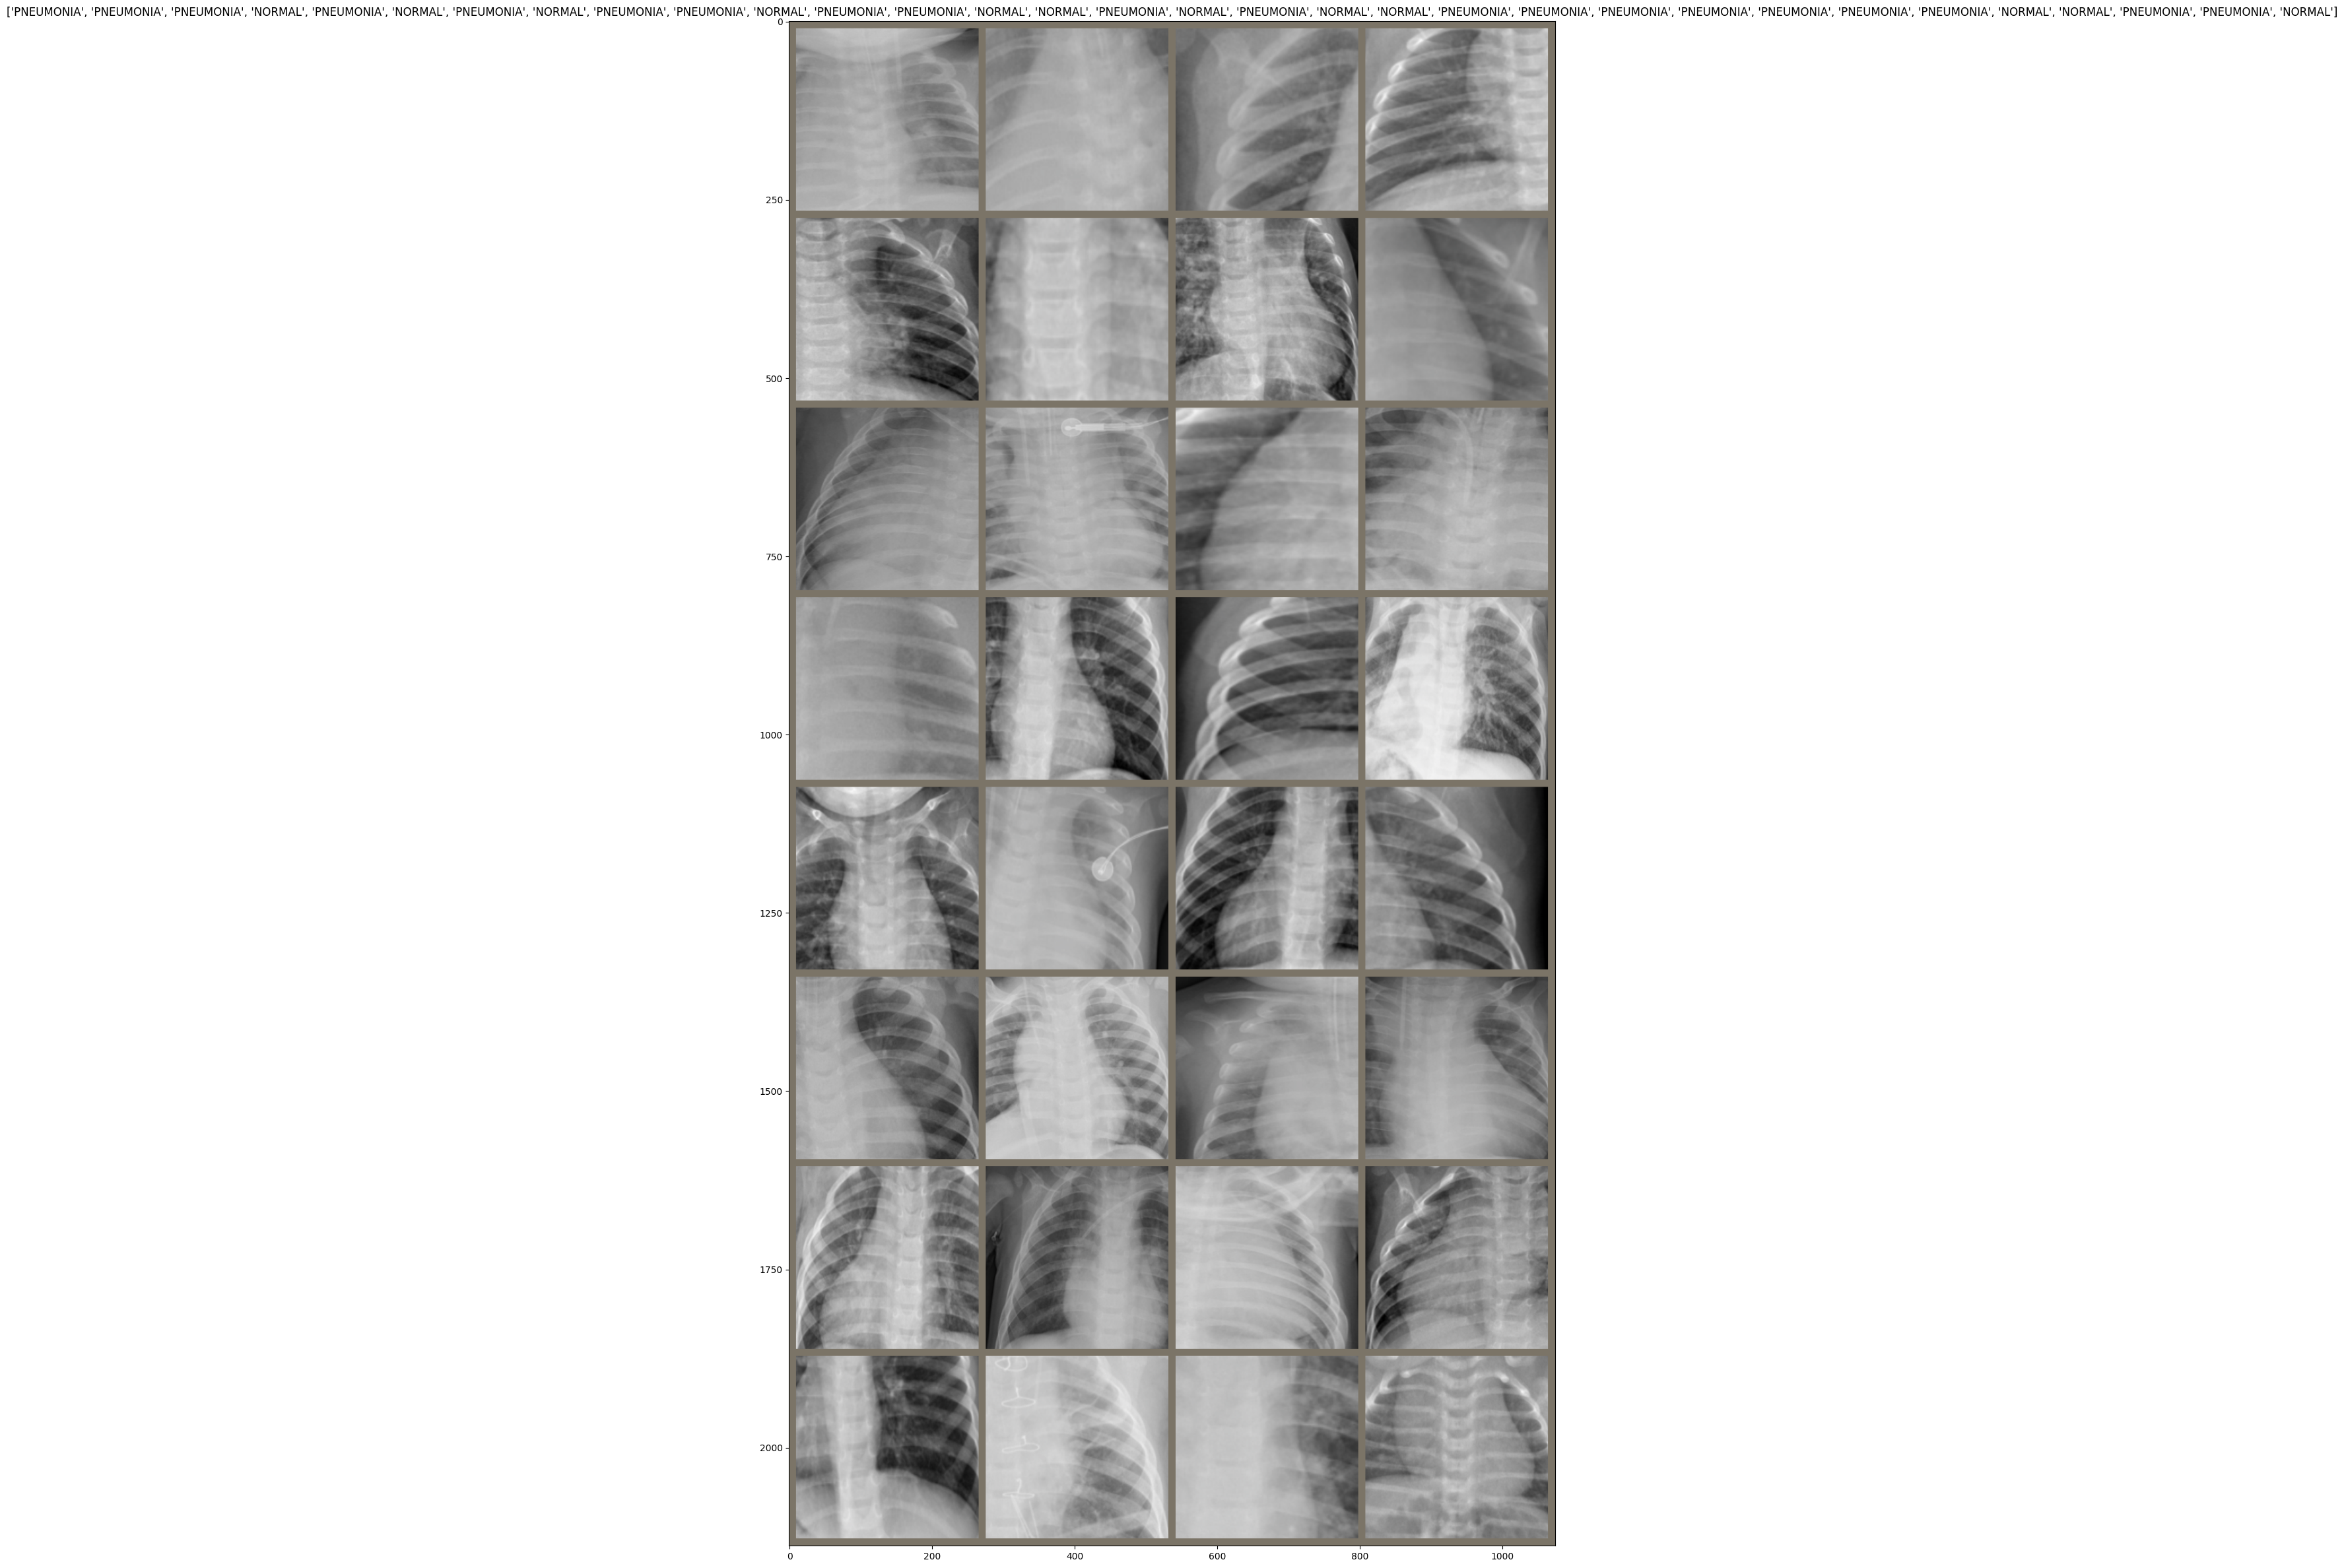

In [11]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

data, label = next(iter(train_dataloader))
inp = make_grid(data, nrow=4, padding=10)
title=[labels[i] for i in label]

plt.figure(figsize=[140, 30])
inp = inp.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)
plt.title(title)
plt.pause(0.001)
plt.show()


In [12]:
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch.nn as nn

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super(AdaptiveConcatPool2d, self).__init__()
        sz = sz or (1, 1)
        self.p1 = torch.nn.AdaptiveAvgPool2d(sz)
        self.p2 = torch.nn.AdaptiveMaxPool2d(sz)

    def forward(self, x):
        return torch.cat([self.p1(x), self.p2(x)], 1)

def get_model():
    model_pretrained = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1) # 获取预训练模型
    # 冻结所有层
    for param in model_pretrained.parameters():
        param.requires_grad = False
    # 微调模型
    # 替换最后两层
    model_pretrained.avgpool = AdaptiveConcatPool2d() # 池化层替换
    model_pretrained.fc = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(4096),
        nn.Dropout(0.5),
        nn.Linear(4096, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Linear(256, 2),
        nn.LogSoftmax(dim=1),
    )
    return model_pretrained

In [14]:
def train(model, dataloader, loss_fn, optimizer, epoch, device='cpu'):
    model.train()

    total_loss = 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = loss_fn(output, target)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    loss_avg = total_loss / len(dataloader)
    return loss_avg

In [15]:
def test(model, dataloader, loss_fn, epoch, device='cpu'):
    model.eval()

    total_loss = 0
    correct = 0
    with torch.inference_mode():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = loss_fn(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            total_loss += loss.item()

    loss_avg = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return loss_avg, accuracy

In [20]:
torch.hub.set_dir('/Volumes/AigoS7Pro/opt/torch/hub')

model = get_model().to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, epoch, device=device)
    test_loss, test_accuracy = test(model, val_dataloader, loss_fn, epoch, device=device)

    print(f'Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.4f}%')


Epoch: 1/10, Train Loss: 0.4326, Test Loss: 0.4718, Test Accuracy: 75.0000%
Epoch: 2/10, Train Loss: 0.3419, Test Loss: 0.6077, Test Accuracy: 68.7500%
Epoch: 3/10, Train Loss: 0.3038, Test Loss: 0.7340, Test Accuracy: 75.0000%
Epoch: 4/10, Train Loss: 0.2959, Test Loss: 0.6014, Test Accuracy: 75.0000%
Epoch: 5/10, Train Loss: 0.2766, Test Loss: 0.5702, Test Accuracy: 81.2500%
Epoch: 6/10, Train Loss: 0.2617, Test Loss: 0.5761, Test Accuracy: 75.0000%
Epoch: 7/10, Train Loss: 0.2434, Test Loss: 0.6389, Test Accuracy: 68.7500%
Epoch: 8/10, Train Loss: 0.2311, Test Loss: 0.9996, Test Accuracy: 62.5000%
Epoch: 9/10, Train Loss: 0.2348, Test Loss: 0.7428, Test Accuracy: 68.7500%
Epoch: 10/10, Train Loss: 0.2084, Test Loss: 0.8911, Test Accuracy: 68.7500%
